# Lecture 8

## The MNIST data set

In [1]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/6c864e25" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

WARNING: Some cells in this notebook take quite a bit of time to run and some
cells crash the kernel when run on the EPFL servers, because of memory
limitations. Therefore this notebook contains the output cells of a run on a local machine.

Let us load the MNIST dataset and plot some examples of the training set.

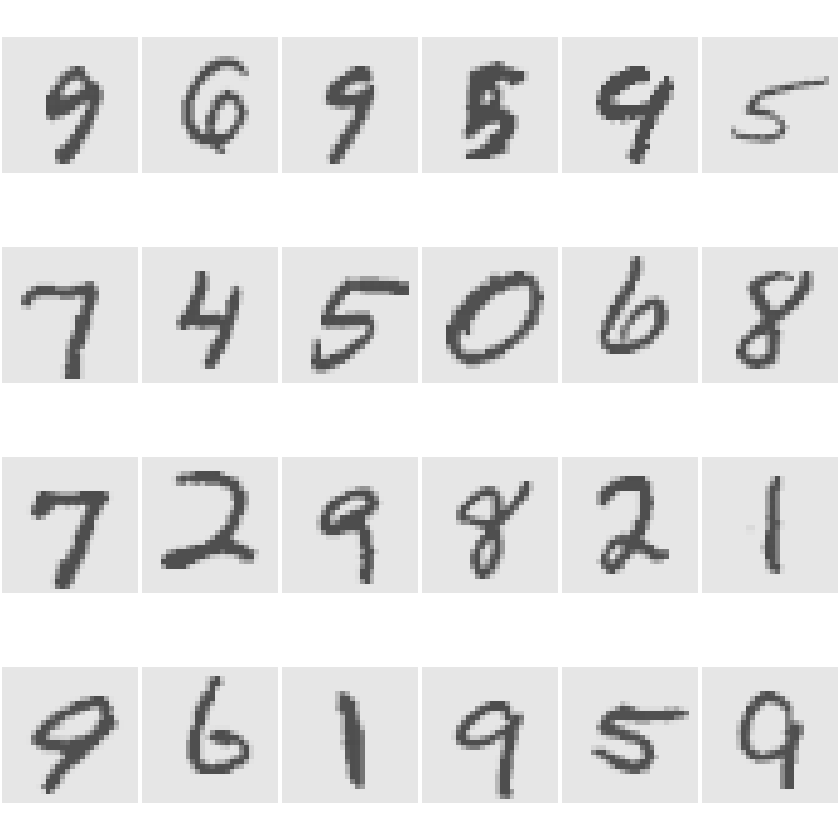

In [2]:
library(keras)
mnist <- dataset_mnist() # loading the data set
par(mfrow = c(4, 6), oma = c(0, 0, 0, 0),
    mar = c(.1, .1, .1, .1), pty="s") # setting some parameters for plotting
for (i in sample(1:60000, 24)) {
    image(t(mnist$train$x[i,28:1,]), col = gray.colors(256, rev = T), axes = FALSE)
}

The inputs are loaded as 60'000 arrays of 28x28 pixels with values between 0 and 255.

In [3]:
print(dim(mnist$train$x))
print(min(mnist$train$x))
print(max(mnist$train$x))

[1] 60000    28    28
[1] 0
[1] 255


To prepare for fitting with Linear Discriminant Analysis we transform the 28x28-
dimensional arrays into 784-dimensional vectors, i.e. the training data is
reshaped from 60'000x28x28 to 60'000x784. We also search for all pixels
that have zero variance accross the whole dataset and exclude them. These are
usually pixels at the borders of the images that are 0 for every input.

In [4]:
X <- array_reshape(mnist$train$x, c(nrow(mnist$train$x), 28^2))
idx.zero.var <- apply(X, 2, var) == 0 # identify pixels with 0 variance
data.train <- data.frame(X[, !idx.zero.var]) # exclude those pixels
data.train$Y <- mnist$train$y

Now we load the MASS library and perform LDA. This will take quite of time,
because the data is rather high-dimensional. If you have installed R on a
sufficiently powerful personal computer, I recommend you to run it there.
(This cell does not run on the EPFL servers, because of memory limitations).

In [5]:
library(MASS)
lda.fit <- lda(Y ~ ., data.train)

Warning message in lda.default(x, grouping, ...):
“variables are collinear”


Let us prepare the test data in the similar way as the training data and plot
the mis-classification table and the accuracy.

In [6]:
X.test <- array_reshape(mnist$test$x, c(nrow(mnist$test$x), 28^2))
data.test <- data.frame(X.test[, !idx.zero.var])
data.test$Y <- mnist$test$y
p <- predict(lda.fit, data.test)
table(p$class, data.test$Y)
mean(data.test$Y == p$class) # accuracy

   
       0    1    2    3    4    5    6    7    8    9
  0  940    0   15    5    0    8   12    2    7    9
  1    0 1096   32    5   12    8    8   30   27    7
  2    1    4  816   25    6    4   11   15    8    1
  3    4    3   34  883    0   44    0    9   27   13
  4    2    2   21    4  888   12   25   22   20   63
  5   13    2    5   25    4  735   29    2   53    6
  6    9    3   37    3    7   15  857    0   10    0
  7    1    0    9   16    2   10    0  864    6   37
  8    9   25   57   29   10   38   16    4  790   12
  9    1    0    6   15   53   18    0   80   26  861

[1] 0.873

Next, we repeat the same with multinomial regression.
We set the argument `MaxNWts = 8000` to tell the function that it is allowed to
build a model with at most 8000 weights. This cell will take even longer to
evaluate, than the one before.

In [7]:
library(nnet)
mn.fit <- multinom(Y ~ ., data.train, MaxNWts = 8000)
p2 <- predict(mn.fit, data.test)
mean(data.test$Y == p2)
table(p2, data.test$Y)

# weights:  7190 (6462 variable)
initial  value 138155.105580 
iter  10 value 33282.974291
iter  20 value 26173.678591
iter  30 value 24672.543031
iter  40 value 24229.953056
iter  50 value 24010.800008
iter  60 value 23932.917353
iter  70 value 23882.106974
iter  80 value 23818.241965
iter  90 value 23749.036339
iter 100 value 23697.758066
final  value 23697.758066 
stopped after 100 iterations


[1] 0.8976

   
p2     0    1    2    3    4    5    6    7    8    9
  0  920    0    7    9    0   11    5    4    5    3
  1    0 1118   15    3    9   10    7   26   33    9
  2    1    3  915   26    2    2    6   23    9    0
  3    1    3   10  888    2   34    0    2   13   10
  4    3    1   10    5  917   12    8   11   11   70
  5   30    1    6   19    1  668   12    1   21    6
  6   16    4   17    7   11   35  919    2   14    6
  7    2    1    8   10    3   10    1  916   10   22
  8    6    4   39   35    4  102    0    5  847   15
  9    1    0    5    8   33    8    0   38   11  868

Now we prepare our first feature representation. To have a similar situation as
in the XOR-Problem, where all input data was around 0, we scale the data first
to lie between 0 and 1 and then we subtract for each pixel the mean over the
entire training set, such that each transformed pixel has a value between -1
and +1. When we do feature engineering there are always many choices.
The exact scaling, for example, does not matter here. What matters is, that the
784 dimensional vectors point in different directions, such that the pair-wise
inner products are sometimes positive and sometimes negative and the relu
non-linearity has an effect. If all inner products would be positive, the relu
non-linearity would not have any effect and the feature representation would be
a linear transformation of the original data.  Linear feature transformation can
be sometimes useful (we will discuss this towards the end of this course), but,
for example, the XOR-problem could not be solved with a purely linear
transformation.

In [8]:
X.p <- X/255
m.X.p <- colMeans(X.p)
X.p <- sweep(X.p, 2, m.X.p) # subtract the means from all input points
feature_vectors <- t(X.p[1:200,]) # we just pick the first 200 images as feature vectors
relu <- function(x) ifelse(x > 0, x, 0)
newdata <- data.frame(relu((X.p %*% feature_vectors))) # create the feature representation
newdata$Y <- data.train$Y

Let us run now multinomial regression on the feature representation.
Note that we have less parameters now, because we went from 784 input dimensions
to a feature representation with 200 features.

In [9]:
mn.features.fit <- multinom(Y ~ ., newdata, MaxNWts = 3000)

# weights:  2020 (1809 variable)
initial  value 138155.105580 
iter  10 value 42283.013913
iter  20 value 34453.953276
iter  30 value 30854.088830
iter  40 value 29663.308584
iter  50 value 29000.061505
iter  60 value 28470.259300
iter  70 value 28123.439179
iter  80 value 27927.197102
iter  90 value 27807.099123
iter 100 value 27725.248837
final  value 27725.248837 
stopped after 100 iterations


To test the fit, we also need to transform the test data in the exact same way
as the training data. Note that we subtract the pixel-wise means of the
training data, because it would not be the same transformation, if we subtracted
instead the means of the test data. Next we compute the feature representation
of the test data and the predictions.

In [10]:
X.p.test <- sweep(X.test/255, 2, m.X.p)
p3 <- predict(mn.features.fit, data.frame(relu(X.p.test %*% feature_vectors)))
mean(data.test$Y == p3)
table(p3, data.test$Y)

[1] 0.9008

   
p3     0    1    2    3    4    5    6    7    8    9
  0  915    0    3    1    4   11    6    2    2    3
  1    0 1119   16    7    6    0    3   17    5    8
  2    6    3  894   13    1    2    3    5    5    2
  3    2    2   28  807    0   10    1    8    6    8
  4   17    0   20    0  913   11   35   11   13   38
  5   14    2    4   19    3  751   26    1   14    2
  6    7    3   11   10    6   18  870    4    5    4
  7    2    0   17   11    9    4    1  934    4   28
  8   12    6   26  134    8   80   12    5  916   27
  9    5    0   13    8   32    5    1   41    4  889

Let us turn now to learning the features with a neural network.
We use `keras` here, as it is much faster than `ADtools`.

`geom_smooth()` using formula 'y ~ x'



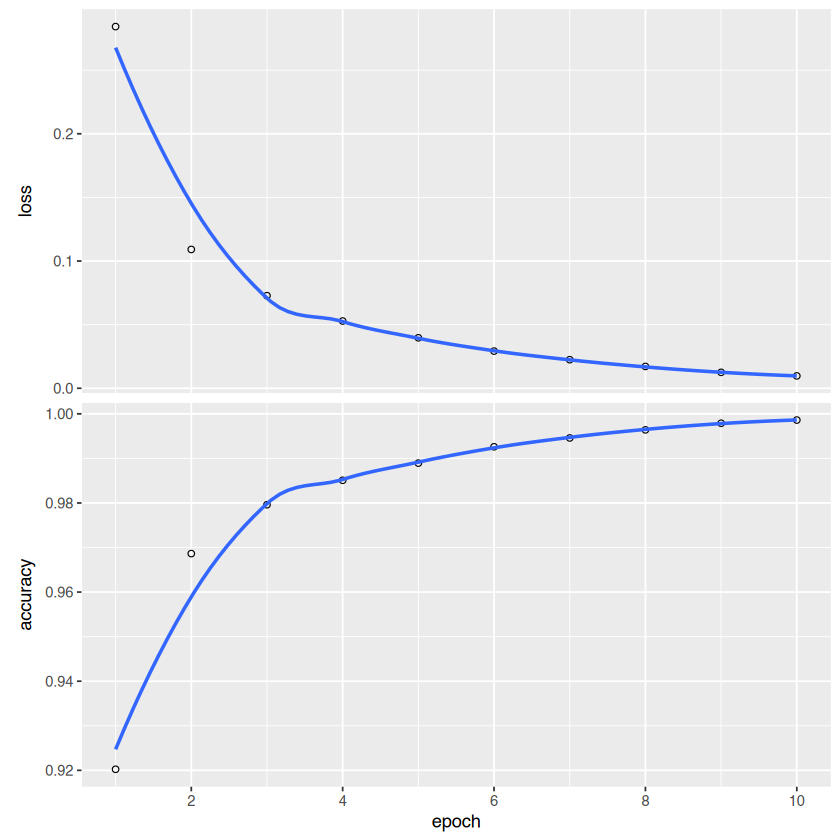

In [11]:
nn <- keras_model_sequential()
nn %>%
  layer_dense(units = 200, activation = 'relu', input_shape = 784) %>%
  layer_dense(units = 10, activation = 'softmax') # with the softmax the outputs of the neurons indicate the probabilities of the digit classes (see slides)
nn %>% compile(
  loss = 'categorical_crossentropy', # this is equivalent to choosing the negative log-likelihood loss (see slides)
  optimizer = 'adam', # this is a fancy version of stochastic gradient descent (usually you don't need to tune the learning rate with ADAM)
  metrics = c('accuracy') # we also track the accuracy during learning.
)
history <- nn %>% fit(
  X.p, to_categorical(data.train$Y), # the target is encoded as a categorical variable (this needs to be done explicitly for keras)
  epochs = 10, batch_size = 128,
  validation_split = 0
)
plot(history)

In the plot you see how the training loss decreases (this is the negative
log-likelihood loss which we optimize) and at the same time the classification
accuracy on the training set increases.

Next we compute test loss and accuracy:

In [12]:
nn %>% evaluate(X.p.test, to_categorical(data.test$Y))

loss   accuracy 
0.07064483 0.97930002

Compare this result again to the ones obtained with LDA, multinomial regression
and multinomial regression with hand-crafted features to see how impressively
well the learned features work on this data set.

In the following cell we extract the learned feature weigths and plot some of
them.

[1] 784 200

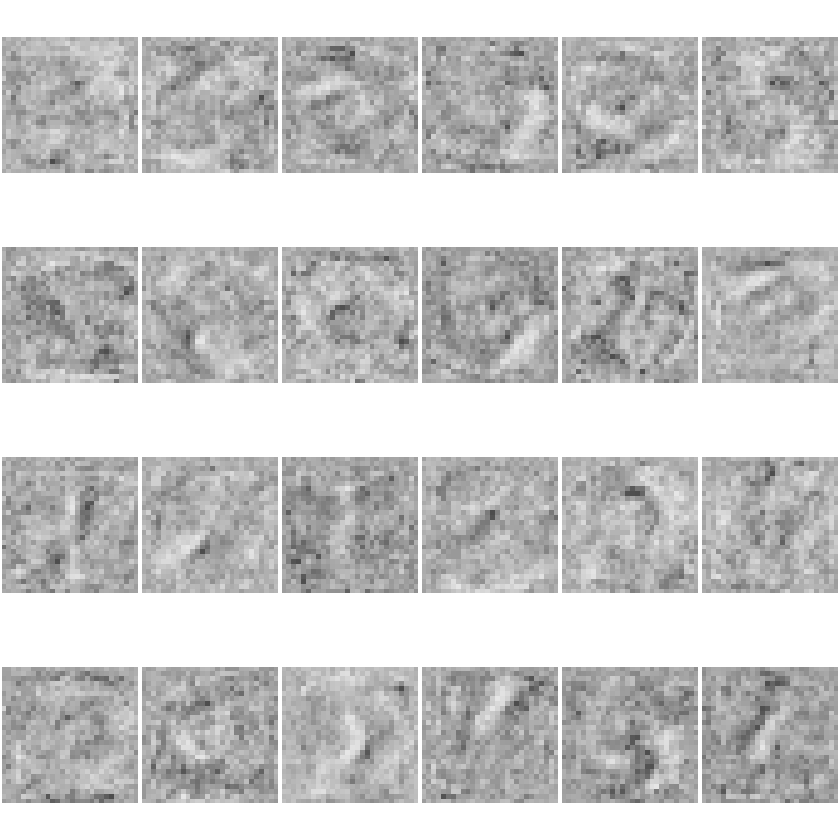

In [13]:
weights <- nn$layers[[1]]$get_weights()[[1]]
dim(weights)
par(mfrow = c(4, 6), oma = c(0, 0, 0, 0),
    mar = c(.1, .1, .1, .1), pty="s")
for (i in sample(1:200, 24)) {
    image(t(array_reshape(weights[,i], c(28, 28))[28:1,]), col = gray.colors(256, rev = T), axes = FALSE)
}

Review again the slide on nomenclature and loss versus accuracy in the lecture
and once you are ready, please head over to the
[quiz](https://moodle.epfl.ch/mod/quiz/view.php?id=1109835) and answer the
questions on the first page.

## Convolutional Neural Networks

In [14]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/68cfa152" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

We do not construct the random Gabor features here. If you are interested you
can read more about [Gabor filters on
Wikipedia](https://en.wikipedia.org/wiki/Gabor_filter). Here we move directly to
convolutional neural networks.

First we reshape the data again to be images of 28x28x1 pixels. The 1 at the end
is used to indicate that we are dealing with gray-scale images; it would be 3,
if we had colour images. Remember that in the video we used volumes to describe
convolutional neural networks. Here the input is 28x28x1 dimensional volume.

In [15]:
X.p.c <- array_reshape(X.p, c(nrow(X.p), 28, 28, 1))
X.p.c.test <- array_reshape(X.p.test, c(nrow(X.p.test), 28, 28, 1))

Now we create our first convolutional neural network.
We will use one convolutional layer with filters of size 10x10, padding 0 (keras
option 'valid'), and stride 1. The output volume of this convolutional layer can
be computed with the formula from the slides to get 19x19x200. Before we feed
this volume to the classifier with 10 softmax neurons, we need to flatten this
volume to a vector of length $19\cdot19\cdot200 = 72200$. This is done with the
special layer `layer_flatten()` below.

In [16]:
conv.nn <- keras_model_sequential()
conv.nn %>%
  layer_conv_2d(200,                         # number of filters
                kernel_size = c(10, 10),     # size of the filter
                strides = c(1, 1),           # stride in x and y dimension
                activation = 'relu',
                input_shape = c(28, 28, 1)) %>%
  layer_flatten() %>%                        # (see text above)
  layer_dense(units = 10, activation = 'softmax')

With the `summary` function we can confirm the volume computation we did above:

In [17]:
summary(conv.nn)

Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d (Conv2D)                     (None, 19, 19, 200)             20200       
________________________________________________________________________________
flatten (Flatten)                   (None, 72200)                   0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 10)                      722010      
Total params: 742,210
Trainable params: 742,210
Non-trainable params: 0
________________________________________________________________________________


Let us now compile and fit this convolutional network.

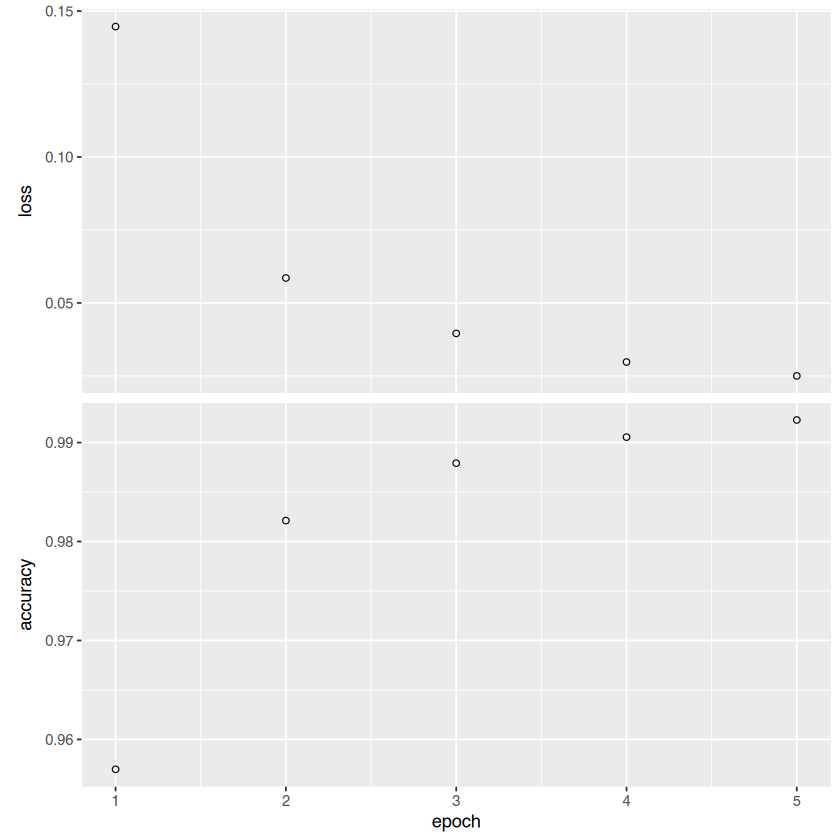

In [18]:
conv.nn %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = 'adam',
  metrics = c('accuracy')
)
history <- conv.nn %>% fit(
  X.p.c, to_categorical(data.train$Y),
  epochs = 5, batch_size = 128,
  validation_split = 0
)
plot(history)

Let us compute the test loss and accuracy.

In [19]:
conv.nn %>% evaluate(X.p.c.test, to_categorical(data.test$Y))

loss  accuracy 
0.0442366 0.9865000

And plot some of the learned filters.

[1]  10  10   1 200

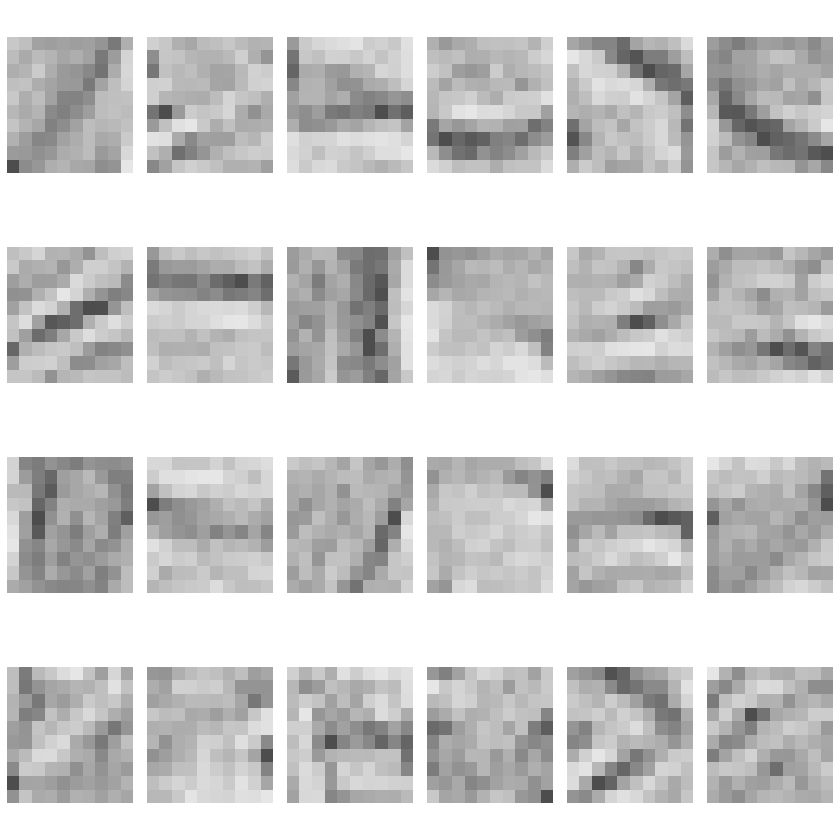

In [20]:
filters <- conv.nn$layers[[1]]$get_weights()[[1]]
dim(filters)
par(mfrow = c(4, 6), oma = c(0, 0, 0, 0),
    mar = c(.1, .1, .1, .1), pty="s")
for (i in sample(1:64, 24)) {
    image(t(array_reshape(filters[,,,i], c(10, 10))[10:1, 1:10]), col = gray.colors(256),
          axes = FALSE, xaxs = 'r', yaxs = 'i')
}

Once you are ready, please head over to the
[quiz](https://moodle.epfl.ch/mod/quiz/view.php?id=1109835) and answer the
questions on the second page.

## Transfer Learning (optional)

The following video is short and optional, but demonstrates a nice idea with
cool applications: the learned features of a neural network trained on a really
large dataset can be used as fixed features to obtain good performance on a
smaller dataset.

In [21]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/d4973d74" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

There is no code for this section.

If you are interested you can look at the code for applying transfer learning to
the flowers data set
[here](https://cran.r-project.org/web/packages/tfhub/vignettes/hub-with-keras.html).

## Regularization and Early Stopping

In [22]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/c27e01a2" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

Let us create a simple dataset. We will use the first 25 points as training data
and the rest as validation set.

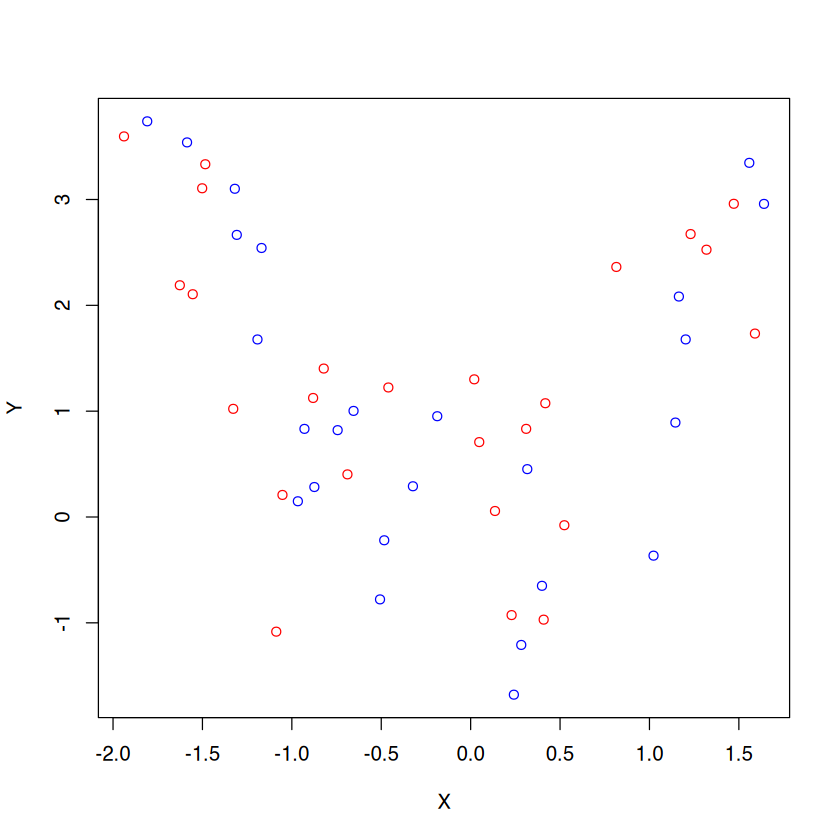

In [23]:
set.seed(3)
X <- 4*runif(50) - 2
Y <- X^2 + rnorm(50)
plot(X, Y, col = c(rep('red', 25), rep('blue', 25)))

Because we will fit different neural networks below, I wrote the following
helper function to compile and fit the neural network and make predictions on a
grid. We include also the argument `callbacks` which will be useful for early
stopping. We use the `mse` loss (Mean Squared Error), which is just the residual
sum of squares (RSS) divided by the number of training samples. This is the
standard negative log-likelihood loss for a regression problem.

In [24]:
myfit <- function(nn, X, Y, grid = seq(-2, 2, length = 100), callbacks = NULL) {
    nn %>% compile(
        loss = 'mse',
        optimizer = 'adam'
    )
    history <- nn %>% fit(
        X, Y,
        validation_split = 0.5,
        callbacks = callbacks,
        epochs = 1500,
    )
    list(nn = nn, history = history, grid = grid, pred = predict(nn, grid))
}

Our first neural network has 2 hidden layers with 50 neurons each.

`geom_smooth()` using formula 'y ~ x'



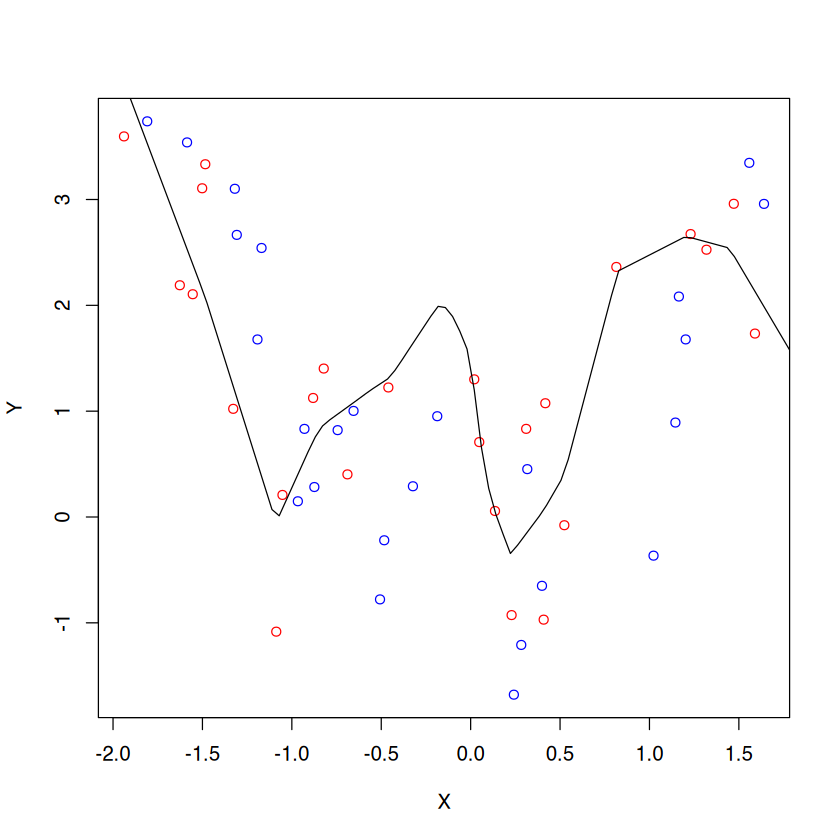

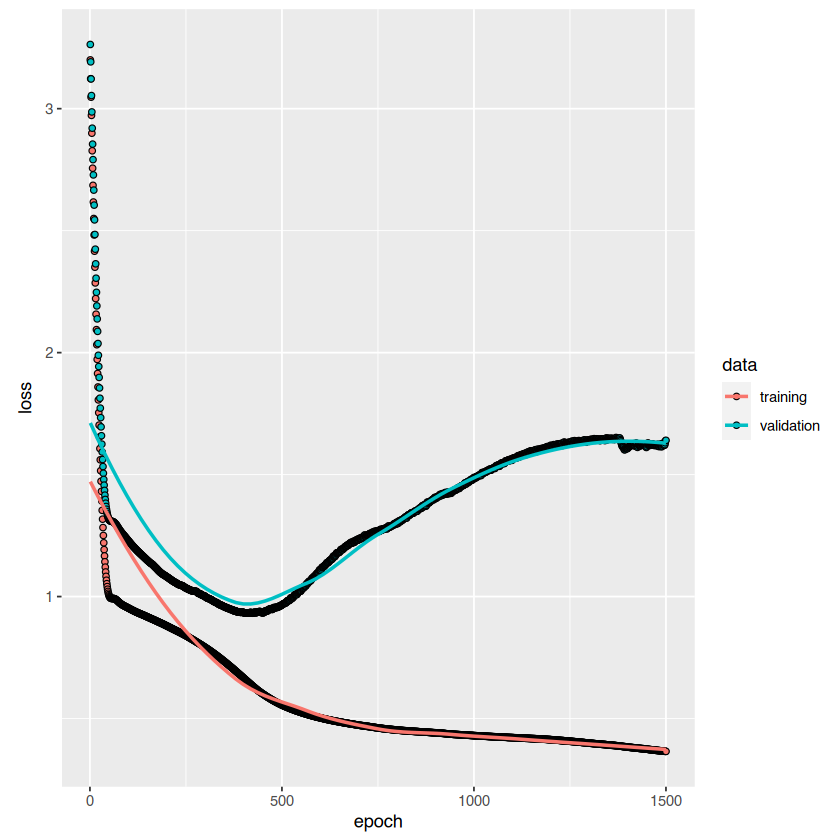

In [25]:
nn1 <- keras_model_sequential() %>%
      layer_dense(units = 50, activation = 'relu', input_shape = c(1)) %>%
      layer_dense(units = 50, activation = 'relu') %>%
      layer_dense(units = 1, activation = 'linear')
res1 <- myfit(nn1, X, Y)
plot(X, Y, col = c(rep('red', 25), rep('blue', 25)))
lines(res1$grid, res1$pred)
plot(res1$history)

Now we repeat the same with regularization in all layers.

`geom_smooth()` using formula 'y ~ x'



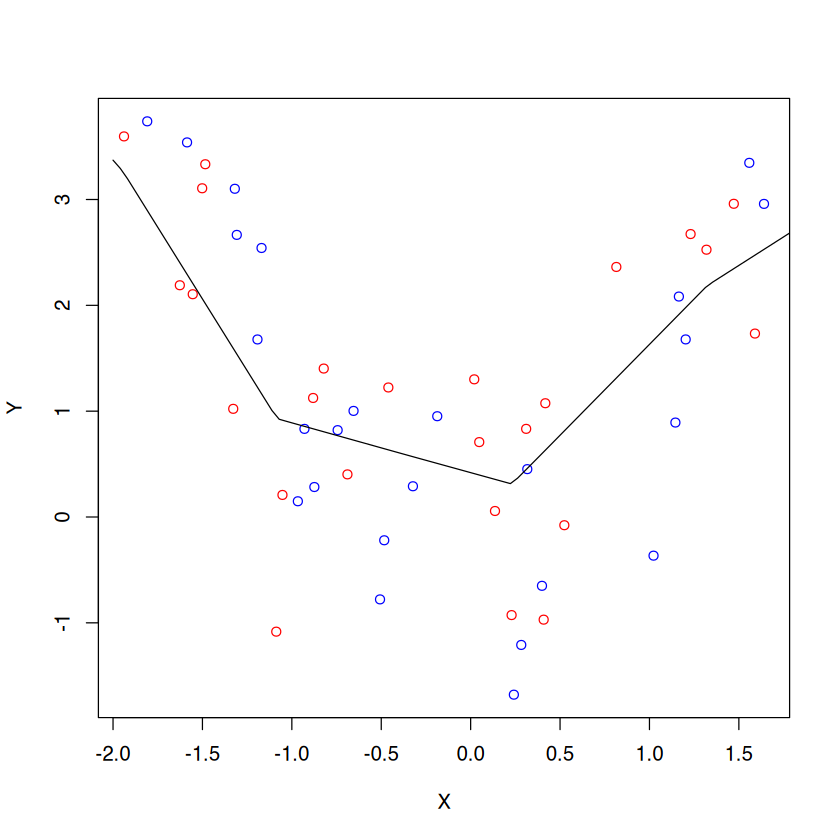

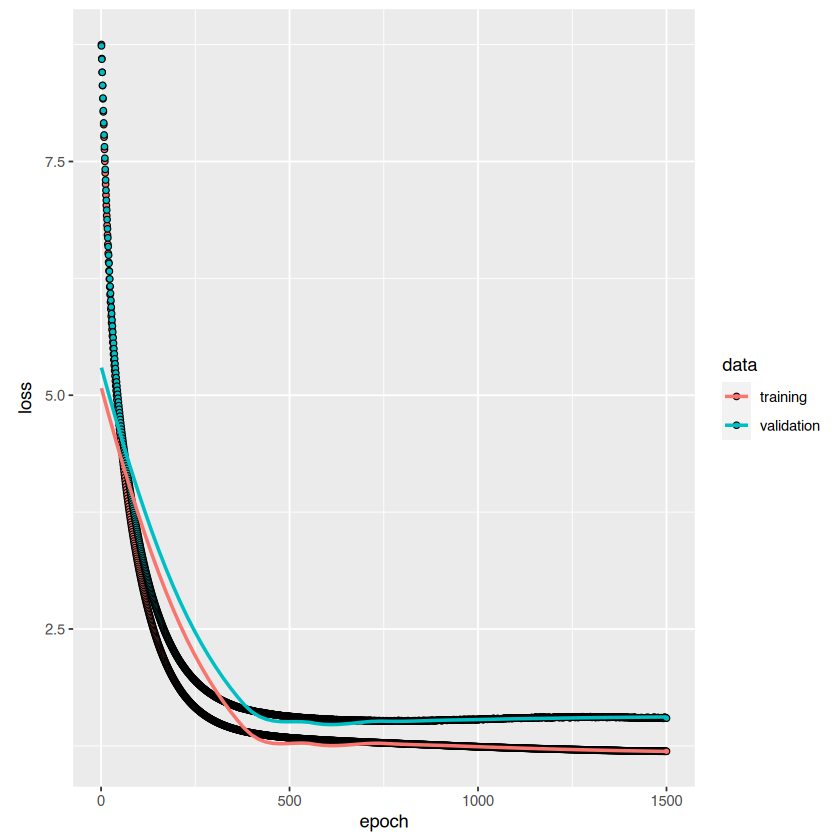

In [26]:
nn2 <- keras_model_sequential() %>%
      layer_dense(units = 50, activation = 'relu', kernel_regularizer = regularizer_l2(l = .1), input_shape = c(1)) %>%
      layer_dense(units = 50, kernel_regularizer = regularizer_l2(l = .1), activation = 'relu') %>%
      layer_dense(units = 1, kernel_regularizer = regularizer_l2(l = .02), activation = 'linear')
res2 <- myfit(nn2, X, Y)
plot(X, Y, col = c(rep('red', 25), rep('blue', 25)))
lines(res2$grid, res2$pred)
plot(res2$history)

Finally, we do not use regularization, but use the callback
`callback_early_stopping` that stops gradient descent when the validation loss
`val_loss` starts to increase.

`geom_smooth()` using formula 'y ~ x'



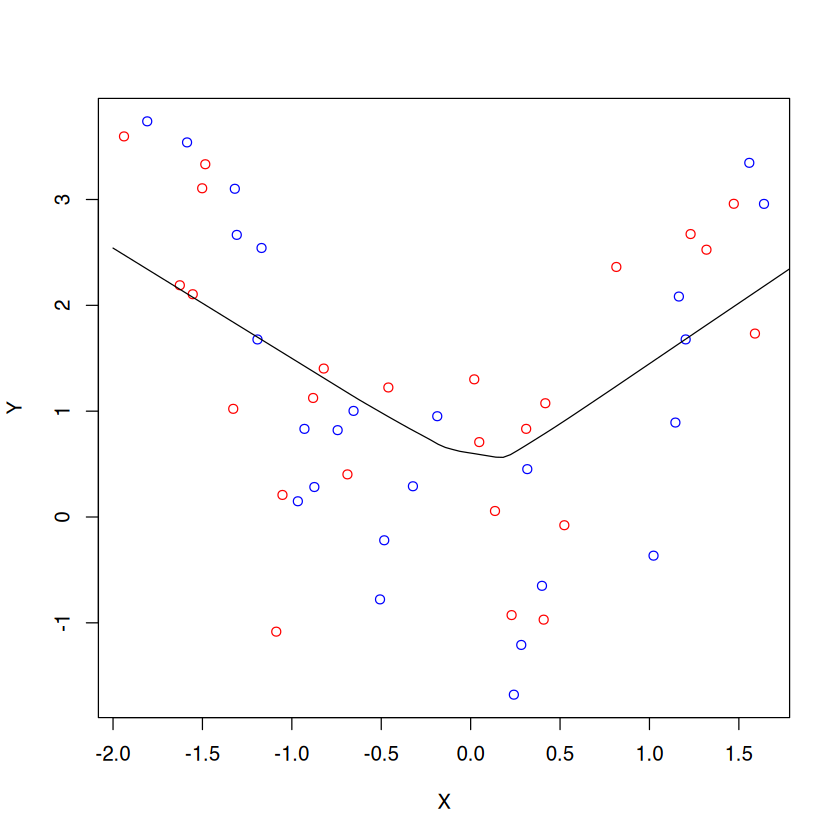

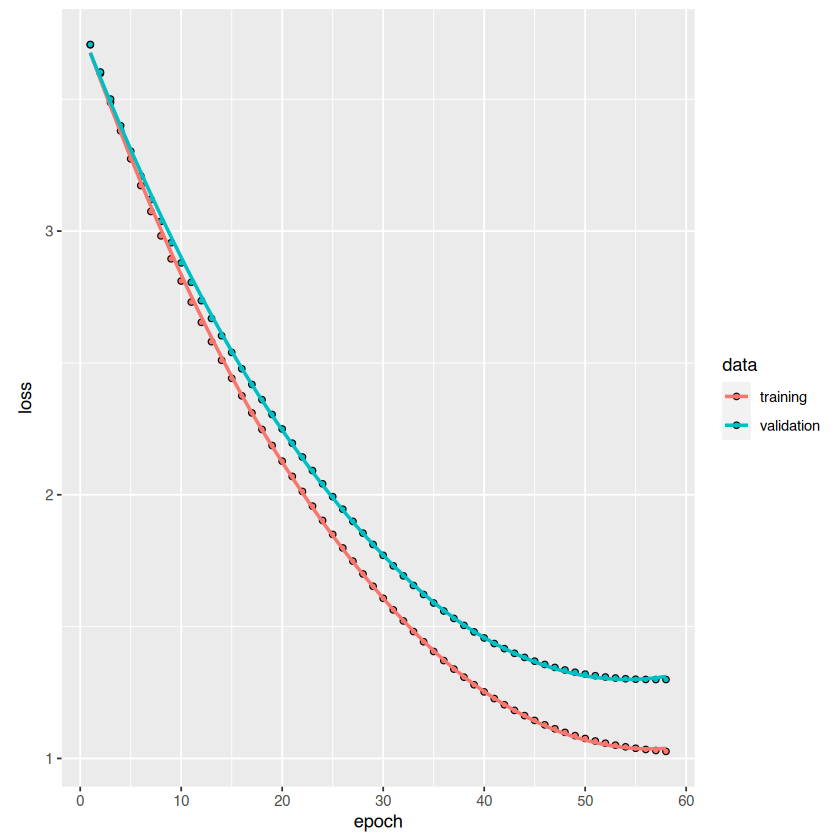

In [27]:
nn3 <- keras_model_sequential() %>%
      layer_dense(units = 50, activation = 'relu', input_shape = c(1)) %>%
      layer_dense(units = 50, activation = 'relu') %>%
      layer_dense(units = 1, activation = 'linear')
callback <- callback_early_stopping(monitor = "val_loss")
res3 <- myfit(nn3, X, Y, callbacks = callback)
plot(X, Y, col = c(rep('red', 25), rep('blue', 25)))
lines(res3$grid, res3$pred)
res3$history$params$epochs <- length(res3$history$metrics$loss) # this is a hack to fix a problem of keras
plot(res3$history)

Once you are ready, please head over to the
[quiz](https://moodle.epfl.ch/mod/quiz/view.php?id=1109835) and answer the
questions on the third page.

## Exercises

### Conceptual

**Q1**
Here below is an image (with padding 1 already applied). We would like to
process it with a convolutional network with one convolution layer with two 3
$\times$ 3 filters (depicted below the image), stride 1 and relu non-linearity.

![](img/Conv.PNG)

(a) Determine the width, height and depth of the volume after the convolutional layer.

(b) Compute the output of the convolutional layer assuming the two biases to be zero.

**Q2**
Given a volume of width $n$, height $n$ and depth $c$:

(a) Convince yourself that the convolution with $k$ filters of size $f\times f\times c$ with stride $s$ and padding $p$ leads to a new volume of size
\begin{equation*}
    \left( \frac{n + 2p - f}{s} + 1\right)\times \left( \frac{n + 2p - f}{s} + 1\right)\times k\, .
\end{equation*}

(b) Keras knows the padding options `valid` and `same`. The first one, `valid`,
means no padding at all. The second one, `same`, means that the output volume
should have the same x and y dimension as the input volume. In this exercise we
compute the padding needed for option `same`.
What padding $p$ do you have to choose such that the input and output volumes have the same width and depth for stride $s=1$. Check you result for the special case of $n=4$ and $f=3$.

## Applied

**Q3**
In this exercise you will try to identify metastatic tissue in histopathologic scans of lymph node sections. The input data consists of greyscale images of 32 $\times$ 32 pixels that were derived from the Histopathalogic Cancer Detection competition  (https://www.kaggle.com/c/histopathologic-cancer-detection).
The original dataset contains colour image patches of 96 $\times$ 96 pixels taken from larger digital pathology scans ($220\,025$ in the training set, and $57\,458$ in the test set).
A positive label indicates that the central 32 $\times$ 32 pixels region contains at least one pixel of tumor tissue.
For this exercise we look at $40\,000$ images from the training set, where the central patch of the original image was extracted and transformed to greyscale to reduce the computational burden.

(a) Load the data with the command
`load(url("https://lcnwww.epfl.ch/bio322/PCaml.rda"))`; two new variables will be added to your workspace: `PCaml_x` and `PCaml_y`.

(b) In general it is recommendable to look at the raw data first. Here, you may want to plot 24 randomly chosen example images that were labelled to contain at least one pixel of tumor tissue and 24 randomly chosen images that were labelled as tumor-free samples. Can you see by eye any difference between the two classes?

(c) Split the data into a training set of size $n=30\,000$ and a test set of size $n=10\,000$.

(d)  Perform logistic regression to have a benchmark.
Plot the ROC, compute the AUC and compute the accuracy on the training and test set.

(e) Fit a convolutional neural network to the data.
Compare ROC, AUC and accuracy of the neural network fit to the logistic regression fit.

(f) (Optional) Play with the network architecture. You may change the number of filters per convolutional layer, the number of layers, add regularization etc. and see how the test error depends on your architectural choices.